In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_theme(style="whitegrid")
sns.color_palette("rocket", as_cmap=True)
sns.set_palette("pastel")
#hide all warnings
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(44)

In [2]:
reviews = pd.read_csv("reviews.csv")
reviews.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
reviews["game_name"]=reviews.game_name.str.split("       ",expand=True,)[0]
reviews.head()

,game_id,game_name,score,author,date,summary
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis..."
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...


In [4]:
stop_words=set(stopwords.words("english"))

#tokenised list of reviews that do not contain stop words
def tokenized_summary(x):
    filtered_sent=[]
    for w in word_tokenize(x):
        if w not in stop_words:
            filtered_sent.append(w)
    return filtered_sent

reviews["tokenised"] = reviews['summary'].apply(lambda x: tokenized_summary(x))

In [5]:
#Lemmatization 
import string
lem = WordNetLemmatizer()
def lemmatized_list(x):
    lemmatized=[]
    for w in x:
        lemmatized.append(lem.lemmatize(w))
    final_string =  " ".join(lemmatized)
    return final_string.translate(str.maketrans('', '', string.punctuation))


reviews["lemmatized"] = reviews['tokenised'].apply(lambda x: lemmatized_list(x))


In [6]:
reviews.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...


In [8]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

def vader_sentiment(x):
    sentiment_dict = sid_obj.polarity_scores(x)
    if sentiment_dict['compound'] > 0.05:
        return pd.Series(['positive', sentiment_dict['compound']])
    elif sentiment_dict['compound'] <= -0.05:
        return pd.Series(['negative', sentiment_dict['compound']])
    else:
        return pd.Series(['neutral',sentiment_dict['compound']])

reviews[["sentiment_label", 'sentiment_value']] = reviews['summary'].apply(lambda x: vader_sentiment(x))

In [9]:
reviews.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731


# Count vectorizer to identify similarity

In [10]:
# reading a list of attributes
attributes=list(line.strip() for line in open('attributes - Copy.csv'))
attributes=" ".join(attributes)
attributes

'action narrative quality soundtrack strategy'

In [11]:
# modifying the structure of the attributes
tempDataFrame=pd.DataFrame({'Game_review':[attributes]})
tempDataFrame=tempDataFrame.transpose()

In [12]:
# combining the selected attributes with the lematized game reviews
description_list1=reviews['lemmatized']
frames = [tempDataFrame, description_list1]
result = pd.concat(frames)
result.columns = ['review']
result=result.reset_index()

In [13]:
result.head()

,index,review
0,Game_review,action narrative quality soundtrack strategy
1,0,Traversing mind character much plot case ’ try...
2,1,Disco Elysium – The Final Cut something rare ...
3,2,Enhanced fantastic fresh content Disco Elysiu...
4,3,A fully voiced cast new content comparable qua...


In [14]:
# applying count vectorizer to the game reviews column
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english')
total_features_words = vec_words.fit_transform(result['review'])

In [15]:
# calculating similarity between game reviews using cosine similiarity
subset_sparse = sparse.csr_matrix(total_features_words)
total_features_review=subset_sparse
total_features_attr=subset_sparse[0,]
similarity=1-pairwise_distances(total_features_attr,total_features_review, metric='cosine')

In [16]:
# merging similarity values into the game reviews dataframe
similarity=pd.DataFrame(similarity)
similarity=similarity.transpose()
similarity.columns = ['similarity']
similarity=similarity.drop(similarity.index[[0]])
reviews_df=reviews.assign(similarity=similarity.values)

In [17]:
# filtering top 10 positive and similar game reviews
reviews_df=reviews_df.sort_values(by=["similarity"],ascending=False)
reviews_df_sim=reviews_df["sentiment_value"]>=0.8
reviews_df[reviews_df_sim].head(10)

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,similarity
1650,83,Dreamscaper,82,The Games Machine,"Sep 2, 2021","In a crowded roguelike landscape, Dreamscaper ...","[In, crowded, roguelike, landscape, ,, Dreamsc...",In crowded roguelike landscape Dreamscaper tr...,positive,0.9236,0.282843
4081,225,Lake,70,Vandal,"Sep 6, 2021",Lake is a peaceful narrative adventure that in...,"[Lake, peaceful, narrative, adventure, interes...",Lake peaceful narrative adventure interestingl...,positive,0.8779,0.269680
785,36,Trials of Fire,90,TheSixthAxis,"Apr 6, 2021","Trials of Fire is uniquely entertaining, and i...","[Trials, Fire, uniquely, entertaining, ,, 's, ...",Trials Fire uniquely entertaining s absolute ...,positive,0.9631,0.212132
674,29,Unpacking,90,Everyeye.it,"Nov 5, 2021",Accompanied by wonderful pixel art and a sooth...,"[Accompanied, wonderful, pixel, art, soothing,...",Accompanied wonderful pixel art soothing sound...,positive,0.8225,0.200000
1334,68,Age of Empires IV,86,IGN Italia,"Oct 25, 2021",Age of Empires IV won't shake the videogame wo...,"[Age, Empires, IV, wo, n't, shake, videogame, ...",Age Empires IV wo nt shake videogame world muc...,positive,0.8320,0.195180
4046,223,Breathedge,75,Multiplayer.it,"Feb 26, 2021","Breathedge is an atypical survival, which trie...","[Breathedge, atypical, survival, ,, tries, sub...",Breathedge atypical survival try subnautica y...,positive,0.8911,0.190693
3763,202,Backbone,60,Shacknews,"Jun 29, 2021",I am disappointed by the mixed feelings I get ...,"[I, disappointed, mixed, feelings, I, get, Bac...",I disappointed mixed feeling I get Backbone I...,positive,0.9737,0.187867
458,19,Death's Door,95,BaziCenter,"Aug 8, 2021",Death's Door is a well crafted Action RPG that...,"[Death, 's, Door, well, crafted, Action, RPG, ...",Death s Door well crafted Action RPG respect a...,positive,0.8479,0.186501
3189,169,Severed Steel,80,ZTGD,"Oct 1, 2021",Severed Steel is a fantastic ride while it las...,"[Severed, Steel, fantastic, ride, last, ,, map...",Severed Steel fantastic ride last map editor ...,positive,0.8981,0.177705
1732,88,Scarlet Nexus,80,Wccftech,"Jun 23, 2021","With masterfully crafted action combat, charmi...","[With, masterfully, crafted, action, combat, ,...",With masterfully crafted action combat charmi...,positive,0.9454,0.176166


# TFIDF FOR SIMILARITY

In [18]:
# reading a list of attributes
attributes=list(line.strip() for line in open('attributes - Copy.csv'))
attributes=" ".join(attributes)
attributes

'action narrative quality soundtrack strategy'

In [19]:
# applying tfidf vectorizer to the game reviews column
vec_words = TfidfVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english')
total_features_words = vec_words.fit_transform(result['review'])

In [20]:
# calculating similarity between game reviews using cosine similiarity
subset_sparse = sparse.csr_matrix(total_features_words)
total_features_review=subset_sparse
total_features_attr=subset_sparse[0,]
similarity=1-pairwise_distances(total_features_attr,total_features_review, metric='cosine')

In [21]:
# merging similarity values into the game reviews dataframe
similarity=pd.DataFrame(similarity)
similarity=similarity.transpose()
similarity.columns = ['similarity']
similarity=similarity.drop(similarity.index[[0]])
reviews_df=reviews.assign(similarity=similarity.values)

In [22]:
# filtering top 10 positive and similar game reviews
reviews_df=reviews_df.sort_values(by=["similarity"],ascending=False)
reviews_df_sim=reviews_df["sentiment_value"]>=0.8
reviews_df[reviews_df_sim].head(10)

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,similarity
1650,83,Dreamscaper,82,The Games Machine,"Sep 2, 2021","In a crowded roguelike landscape, Dreamscaper ...","[In, crowded, roguelike, landscape, ,, Dreamsc...",In crowded roguelike landscape Dreamscaper tr...,positive,0.9236,0.202030
785,36,Trials of Fire,90,TheSixthAxis,"Apr 6, 2021","Trials of Fire is uniquely entertaining, and i...","[Trials, Fire, uniquely, entertaining, ,, 's, ...",Trials Fire uniquely entertaining s absolute ...,positive,0.9631,0.188594
4081,225,Lake,70,Vandal,"Sep 6, 2021",Lake is a peaceful narrative adventure that in...,"[Lake, peaceful, narrative, adventure, interes...",Lake peaceful narrative adventure interestingl...,positive,0.8779,0.180363
1334,68,Age of Empires IV,86,IGN Italia,"Oct 25, 2021",Age of Empires IV won't shake the videogame wo...,"[Age, Empires, IV, wo, n't, shake, videogame, ...",Age Empires IV wo nt shake videogame world muc...,positive,0.8320,0.177076
458,19,Death's Door,95,BaziCenter,"Aug 8, 2021",Death's Door is a well crafted Action RPG that...,"[Death, 's, Door, well, crafted, Action, RPG, ...",Death s Door well crafted Action RPG respect a...,positive,0.8479,0.150735
1732,88,Scarlet Nexus,80,Wccftech,"Jun 23, 2021","With masterfully crafted action combat, charmi...","[With, masterfully, crafted, action, combat, ,...",With masterfully crafted action combat charmi...,positive,0.9454,0.150691
4129,227,Last Stop,60,Screen Rant,"Jul 21, 2021","Overall, Last Stop is something of a mixed bag...","[Overall, ,, Last, Stop, something, mixed, bag...",Overall Last Stop something mixed bag At bes...,positive,0.9621,0.145608
3673,197,The Dark Pictures Anthology: House of Ashes,80,PC Gamer,"Oct 21, 2021","Great monsters, stunning locations and a quali...","[Great, monsters, ,, stunning, locations, qual...",Great monster stunning location quality myste...,positive,0.8979,0.143949
4985,283,Warhammer Age of Sigmar: Storm Ground,80,Checkpoint Gaming,"Jun 1, 2021",A great strategy title for fans of tactical tu...,"[A, great, strategy, title, fans, tactical, tu...",A great strategy title fan tactical turnbased ...,positive,0.8898,0.142249
5039,285,King's Bounty II,60,Checkpoint Gaming,"Aug 25, 2021",King’s Bounty II has all the ingredients of a ...,"[King, ’, Bounty, II, ingredients, great, stra...",King ’ Bounty II ingredient great strategy gam...,positive,0.9071,0.140262


# CLUSTERING

## Using Count Vectorizer with sum aggregation for clustering

In [217]:
# applying countvectorizer vectorizer to the lematized game reviews column
#vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',min_df=10, max_features=500)
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',max_features=500)
vectors = vec_words.fit_transform(reviews['lemmatized'])

feature_names = vec_words.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
count = pd.DataFrame(denselist, columns=feature_names)

In [218]:
# looking at column names
column_names = count.columns
list(column_names)

['2',
 '2021',
 '2042',
 '3',
 '4',
 '5',
 '6',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'conte

In [219]:
# joining the game reviews df with the count vectorized attributes
final_df = reviews.join(count)
final_df.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,worth,worthy,writing,year,–,—,‘,’,“,”
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0,0,0,0,0,0,0,3,0,0
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,1,0,0,3,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,1,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,0,0,0,1,0,0,0,0,0,0
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0,0,0,0,0,0,0,0,0,0


In [220]:
# only include relevant attributes for clustering
attributes = pd.read_csv("topic-grouping-v2.csv")
attributes=attributes[["word","Group"]]
attributes=attributes[attributes["Group"].str.contains("ignore")==False]
attributes

,word,Group
0,dark,tone
1,entertaining,tone
2,strategy,strategy based gameplay
3,mission,game design
4,easily,difficulty
...,...,...
162,life,narrative
164,pretty,visuals
166,gorgeous,visuals
168,time,playthrough time


In [221]:
# identifying list of columns to keep
tokeep=list(attributes["word"])
tokeep

['dark',
 'entertaining',
 'strategy',
 'mission',
 'easily',
 'battle',
 'fan',
 'chance',
 'turnbased',
 'campaign',
 'openworld',
 'artistic',
 'puzzle',
 'technical',
 'issue',
 'sniper',
 'expected',
 'problem',
 'rough',
 'interesting',
 'flaw',
 'enjoy',
 'exciting',
 'animation',
 'hour',
 'tactical',
 'money',
 'worth',
 'aesthetic',
 'combat',
 'system',
 'world',
 'narrative',
 'element',
 'hard',
 'experience',
 'character',
 'exploration',
 'lost',
 'space',
 'fantasy',
 'remaster',
 'polish',
 'intriguing',
 'visuals',
 'survival',
 'pace',
 'mode',
 'boring',
 'cute',
 'storyline',
 'shooter',
 'playthrough',
 'action',
 'cry',
 'vr',
 'fighting',
 'happy',
 'gameplay',
 'design',
 'adventure',
 'mechanic',
 'story',
 'fun',
 'management',
 'decision',
 'multiplayer',
 'classic',
 'single',
 'coop',
 'inspiration',
 'traditional',
 'roleplaying',
 'fight',
 'jrpg',
 'genius',
 'simulator',
 'refreshing',
 'pleasant',
 'taste',
 'niche',
 'pleasure',
 'genre',
 'music',
 

In [222]:
# identifying current list of columns
cols=list(final_df.columns)
cols

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 '2',
 '2021',
 '2042',
 '3',
 '4',
 '5',
 '6',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clea

In [223]:
contentstokeep=final_df.iloc[:,:10]

In [224]:
# removing the column names that aren't part of the list of columns to keep
final_df.iloc[:,10:]
for i in cols:
    if i not in tokeep:
        final_df.drop(columns=[i], inplace=True)

In [225]:
final_df=contentstokeep.join(final_df)
final_df

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,strategy,survival,tactical,technical,time,turnbased,visuals,vr,world,worth
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0,0,0,0,0,0,0,0,1,0
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,0,0,0,0,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,0,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,0,0,0,0,0,0,0,0,0,0
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,320,eFootball 2022,30,PC Gamer,"Oct 13, 2021","In PR terms, it's the world's costliest public...","[In, PR, terms, ,, 's, world, 's, costliest, p...",In PR term s world s costliest public beta T...,neutral,0.0000,...,0,0,0,0,0,0,0,0,1,0
5504,320,eFootball 2022,28,GameStar,"Oct 10, 2021",It's the worst-rated game on Steam for a reaso...,"[It, 's, worst-rated, game, Steam, reason, ,, ...",It s worstrated game Steam reason soccer fan ...,negative,-0.6486,...,0,0,0,0,0,0,0,0,0,0
5505,320,eFootball 2022,20,Gamer.no,"Oct 10, 2021","The game is straight up horrible, and I can’t ...","[The, game, straight, horrible, ,, I, ’, under...",The game straight horrible I ’ understand som...,neutral,-0.0258,...,0,0,0,0,0,0,0,0,0,0
5506,320,eFootball 2022,20,PC Games,"Oct 5, 2021",The Pro Evolution Soccer series was all the ti...,"[The, Pro, Evolution, Soccer, series, time, wo...",The Pro Evolution Soccer series time worthy op...,negative,-0.0644,...,0,0,0,0,1,0,0,0,0,0


In [226]:
final_df.columns # left with 86 columns

Index(['game_id', 'game_name', 'score', 'author', 'date', 'summary',
       'tokenised', 'lemmatized', 'sentiment_label', 'sentiment_value',
       'action', 'adventure', 'aesthetic', 'age', 'animation', 'artistic',
       'attention', 'battle', 'boring', 'campaign', 'challenging', 'chance',
       'character', 'classic', 'combat', 'complete', 'coop', 'dark',
       'decision', 'design', 'easily', 'effect', 'element', 'enjoy',
       'entertaining', 'entry', 'exciting', 'experience', 'exploration', 'fan',
       'fantasy', 'fascinating', 'fight', 'flaw', 'franchise', 'fun',
       'gameplay', 'genius', 'genre', 'gorgeous', 'hard', 'hero', 'hour',
       'interesting', 'intriguing', 'issue', 'jrpg', 'life', 'lost',
       'management', 'mechanic', 'mission', 'mode', 'multiplayer', 'music',
       'narrative', 'nice', 'openworld', 'pace', 'pc', 'play', 'pleasant',
       'polish', 'pretty', 'problem', 'puzzle', 'remaster', 'rough', 'run',
       'series', 'shooter', 'simulator', 'single'

In [227]:
# creating 2 separate data frames for calculations

# df with just the attributes 
final_df2=final_df.drop(columns=["game_name","author","date","summary","tokenised","lemmatized","sentiment_label","score","sentiment_value"])

# df with just the metascore and sentiment value
final_df3=final_df[["game_id","score","sentiment_value"]]

In [228]:
# aggregate values of each attribute column by the sum for each video game
final_df4=final_df2.groupby("game_id").sum() 
final_df5=final_df3.groupby("game_id").mean() # getting the mean metascore and sentiment for each video game
final_df6 = final_df5.join(final_df4)
final_df6.head()

,score,sentiment_value,action,adventure,aesthetic,age,animation,artistic,attention,battle,...,strategy,survival,tactical,technical,time,turnbased,visuals,vr,world,worth
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,5,0
1,91.962963,0.790196,0,4,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
2,91.100000,0.777425,2,3,0,0,0,0,0,0,...,0,0,0,2,4,0,1,0,0,2
3,89.782609,0.737909,0,9,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,4,1
4,88.970588,0.745638,1,6,0,2,0,0,0,0,...,0,0,0,0,7,0,1,0,6,4


In [232]:
grps=list(attributes["Group"].unique())
final_df7=final_df6.iloc[:,:2]
cols=final_df6.columns[2:]
cols

Index(['action', 'adventure', 'aesthetic', 'age', 'animation', 'artistic',
       'attention', 'battle', 'boring', 'campaign', 'challenging', 'chance',
       'character', 'classic', 'combat', 'complete', 'coop', 'dark',
       'decision', 'design', 'easily', 'effect', 'element', 'enjoy',
       'entertaining', 'entry', 'exciting', 'experience', 'exploration', 'fan',
       'fantasy', 'fascinating', 'fight', 'flaw', 'franchise', 'fun',
       'gameplay', 'genius', 'genre', 'gorgeous', 'hard', 'hero', 'hour',
       'interesting', 'intriguing', 'issue', 'jrpg', 'life', 'lost',
       'management', 'mechanic', 'mission', 'mode', 'multiplayer', 'music',
       'narrative', 'nice', 'openworld', 'pace', 'pc', 'play', 'pleasant',
       'polish', 'pretty', 'problem', 'puzzle', 'remaster', 'rough', 'run',
       'series', 'shooter', 'simulator', 'single', 'sniper', 'space', 'story',
       'strategy', 'survival', 'tactical', 'technical', 'time', 'turnbased',
       'visuals', 'vr', 'world', '

In [233]:
# merging the counts for each word by the identified groups
for i in grps:
    df=attributes[attributes["Group"]==i]
    # cols = columns in the current dataframe
    final_df6[i]=0
    for j in cols:
        if j in list(df["word"]):
            final_df6[i]=final_df6[i]+final_df6[j]

In [247]:
final_df7=final_df7.join(final_df6.iloc[:,-13:])

In [248]:
final_df7

,score,sentiment_value,tone,strategy based gameplay,game design,difficulty,skill based gameplay,enjoyment,luck based gameplay,world building,technical performance,innovative,playthrough time,value,sound track
game_id,,,,,,,,,,,,,,,
0,97.272727,0.531809,0,0,10,0,0,0,0,5,4,2,1,0,0
1,91.962963,0.790196,0,0,16,0,1,7,0,22,1,6,1,0,1
2,91.100000,0.777425,0,0,11,0,2,9,0,2,7,10,7,2,0
3,89.782609,0.737909,0,9,23,1,1,10,0,6,5,0,4,1,0
4,88.970588,0.745638,4,1,21,0,4,15,0,7,7,7,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,48.800000,0.250970,1,0,8,0,3,1,0,0,2,2,3,0,0
317,48.428571,-0.250000,0,0,6,0,2,2,0,0,2,1,5,1,0
318,43.846154,0.304862,2,0,10,0,0,7,0,0,2,2,1,1,5


In [249]:
# applying cosine similiarty
from sklearn.metrics.pairwise import cosine_similarity
dist=1-cosine_similarity(final_df7)
dist

array([[ 1.11022302e-16,  2.25766475e-02,  1.22535341e-02, ...,
         2.77631581e-02,  1.82366906e-02,  1.01987643e-02],
       [ 2.25766475e-02, -2.22044605e-16,  2.86033334e-02, ...,
         3.74468643e-02,  2.88092410e-02,  1.83034180e-02],
       [ 1.22535341e-02,  2.86033334e-02,  0.00000000e+00, ...,
         1.80458934e-02,  1.59753893e-02,  4.59151203e-03],
       ...,
       [ 2.77631581e-02,  3.74468643e-02,  1.80458934e-02, ...,
        -2.22044605e-16,  9.56396337e-03,  2.63321740e-02],
       [ 1.82366906e-02,  2.88092410e-02,  1.59753893e-02, ...,
         9.56396337e-03,  3.33066907e-16,  2.38319737e-02],
       [ 1.01987643e-02,  1.83034180e-02,  4.59151203e-03, ...,
         2.63321740e-02,  2.38319737e-02,  0.00000000e+00]])

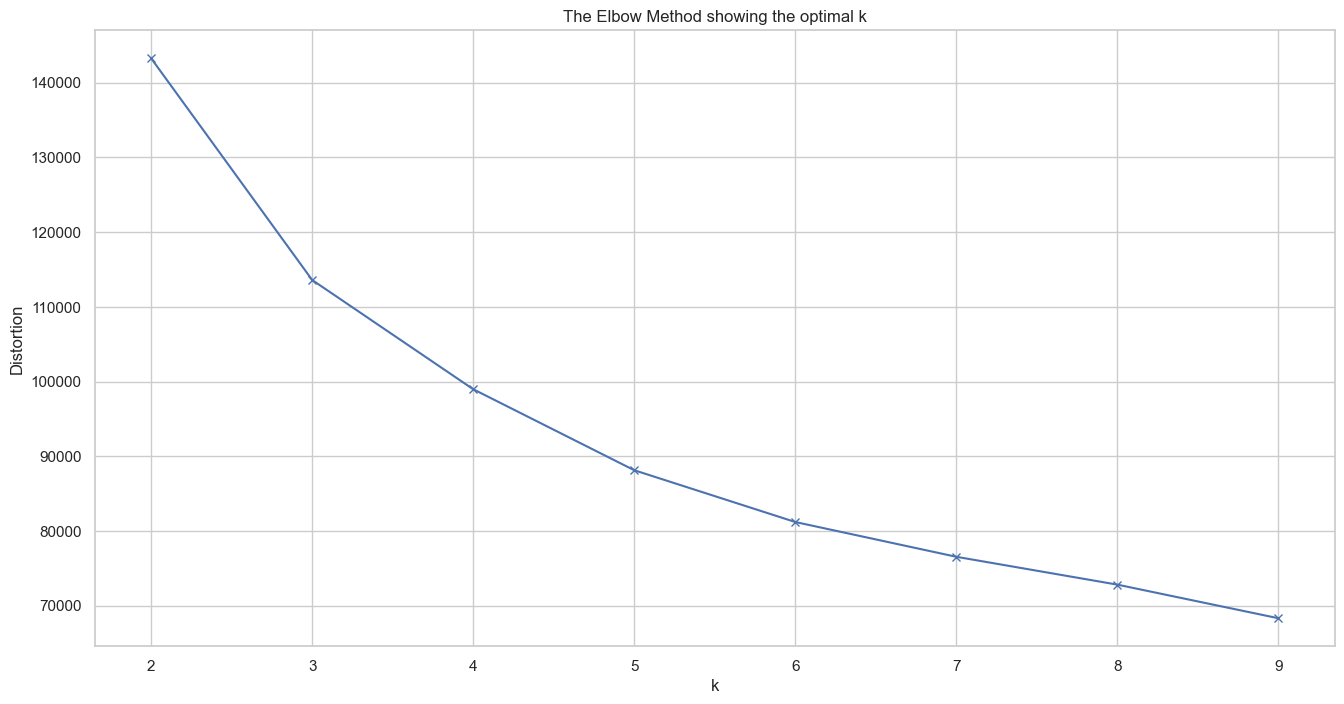

In [250]:
# using elbow method to determine number of clusters 
from sklearn.cluster import KMeans
vals = []
for i in range(2,10):
    kmeans=KMeans(n_clusters=i)
    model = kmeans.fit(final_df7)
    vals.append(model.inertia_)
K=range(2,10)
plt.figure(figsize=(16,8))
plt.plot(K, vals, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [256]:
# k-means clustering with 6 clusters
from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(final_df6)
clusters = km.labels_.tolist()

In [257]:
import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [258]:
# creating dataframe for clusters
dictionary={"clusters":clusters}
clusts=pd.DataFrame(dictionary)
clusts.head()

,clusters
0,0
1,2
2,0
3,0
4,2


In [259]:
# joining the clusters to the grouped file
games=final_df7.join(clusts)
games.head()

,score,sentiment_value,tone,strategy based gameplay,game design,difficulty,skill based gameplay,enjoyment,luck based gameplay,world building,technical performance,innovative,playthrough time,value,sound track,clusters
game_id,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0,0,10,0,0,0,0,5,4,2,1,0,0,0
1,91.962963,0.790196,0,0,16,0,1,7,0,22,1,6,1,0,1,2
2,91.100000,0.777425,0,0,11,0,2,9,0,2,7,10,7,2,0,0
3,89.782609,0.737909,0,9,23,1,1,10,0,6,5,0,4,1,0,0
4,88.970588,0.745638,4,1,21,0,4,15,0,7,7,7,8,4,0,2


In [260]:
# seeing how many games are in each cluster
games["clusters"].value_counts()

0    255
2     65
1      1
Name: clusters, dtype: int64

In [261]:
# average metascore per cluster
grouped=games["score"].groupby(games["clusters"])

grouped.mean()

clusters
0    73.529412
1    81.542169
2    76.932125
Name: score, dtype: float64

In [262]:
# average sentiment per cluster
grouped=games["sentiment_value"].groupby(games["clusters"])

grouped.mean()

clusters
0    0.525321
1    0.656619
2    0.542337
Name: sentiment_value, dtype: float64

In [279]:
# selecting only the attributes columns
attributes2=final_df7.iloc[:,2:]
attributes2.columns.tolist()

['tone',
 'strategy based gameplay',
 'game design',
 'difficulty',
 'skill based gameplay',
 'enjoyment',
 'luck based gameplay',
 'world building',
 'technical performance',
 'innovative',
 'playthrough time',
 'value',
 'sound track']

In [303]:
# identifying the closest attributes to each cluster centroid
# code taken from : https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :3]:
        print(' %s' % attributes2.columns.tolist()[ind], end='')
        print()

Top terms per cluster:
Cluster 0:
 tone
Cluster 1:


IndexError: list index out of range

In [291]:
gamenames=list(final_df.game_name.unique())

In [292]:
# converting numpy array of similarity into dataframe
dist2=pd.DataFrame(dist)
dist2=dist2.set_axis([gamenames], axis=1)
dist2=dist2.set_axis([gamenames], axis="index")
dist2

,Disco Elysium: The Final Cut,Final Fantasy XIV: Endwalker,Forza Horizon 5,Chicory: A Colorful Tale,Psychonauts 2,Streets of Rage 4: Mr. X Nightmare,It Takes Two,Hitman 3,Wildermyth,Final Fantasy VII Remake Intergrade,...,Foreclosed,Buildings Have Feelings Too!,Dungeons & Dragons: Dark Alliance,AWAY: The Survival Series,Grand Theft Auto: The Trilogy - The Definitive Edition,Demon Skin,Arkham Horror: Mother's Embrace,Of Bird and Cage,Balan Wonderworld,eFootball 2022
Disco Elysium: The Final Cut,1.110223e-16,2.257665e-02,0.012254,0.022155,0.029025,0.027020,0.021732,0.148374,0.009905,0.027783,...,0.026911,0.004006,0.303068,0.022459,0.021287,0.006770,7.625740e-03,2.776316e-02,1.823669e-02,0.010199
Final Fantasy XIV: Endwalker,2.257665e-02,-2.220446e-16,0.028603,0.025287,0.024637,0.040968,0.029175,0.094967,0.021670,0.028400,...,0.037821,0.033148,0.281621,0.039831,0.045296,0.031258,3.430188e-02,3.744686e-02,2.880924e-02,0.018303
Forza Horizon 5,1.225353e-02,2.860333e-02,0.000000,0.020451,0.011397,0.024783,0.016242,0.111479,0.009848,0.023511,...,0.021567,0.012284,0.255044,0.014568,0.017186,0.008225,6.816018e-03,1.804589e-02,1.597539e-02,0.004592
Chicory: A Colorful Tale,2.215461e-02,2.528706e-02,0.020451,0.000000,0.011228,0.015287,0.005712,0.088034,0.012079,0.030264,...,0.013093,0.018426,0.251331,0.027207,0.038819,0.016785,1.938933e-02,1.628470e-02,1.552822e-02,0.023542
Psychonauts 2,2.902496e-02,2.463663e-02,0.011397,0.011228,0.000000,0.020252,0.009246,0.068708,0.016251,0.024504,...,0.012996,0.027639,0.201111,0.024226,0.035014,0.017907,1.916949e-02,1.290643e-02,1.638894e-02,0.016332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demon Skin,6.769912e-03,3.125759e-02,0.008225,0.016785,0.017907,0.018141,0.014360,0.120673,0.005921,0.030963,...,0.009444,0.005467,0.257179,0.019273,0.029549,0.000000,2.677106e-03,1.972877e-02,1.774583e-02,0.010758
Arkham Horror: Mother's Embrace,7.625740e-03,3.430188e-02,0.006816,0.019389,0.019169,0.020627,0.015326,0.135652,0.006958,0.030060,...,0.014386,0.004812,0.270737,0.021881,0.025925,0.002677,1.110223e-16,2.249867e-02,1.740560e-02,0.009748
Of Bird and Cage,2.776316e-02,3.744686e-02,0.018046,0.016285,0.012906,0.019179,0.009286,0.096917,0.023387,0.043086,...,0.020844,0.028597,0.228225,0.028565,0.037751,0.019729,2.249867e-02,-2.220446e-16,9.563963e-03,0.026332
Balan Wonderworld,1.823669e-02,2.880924e-02,0.015975,0.015528,0.016389,0.017315,0.005503,0.124987,0.016180,0.042937,...,0.023562,0.021358,0.245244,0.028219,0.026713,0.017746,1.740560e-02,9.563963e-03,3.330669e-16,0.023832


In [293]:
# MDS plot for similarity
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist2) 
xs,ys = pos.T

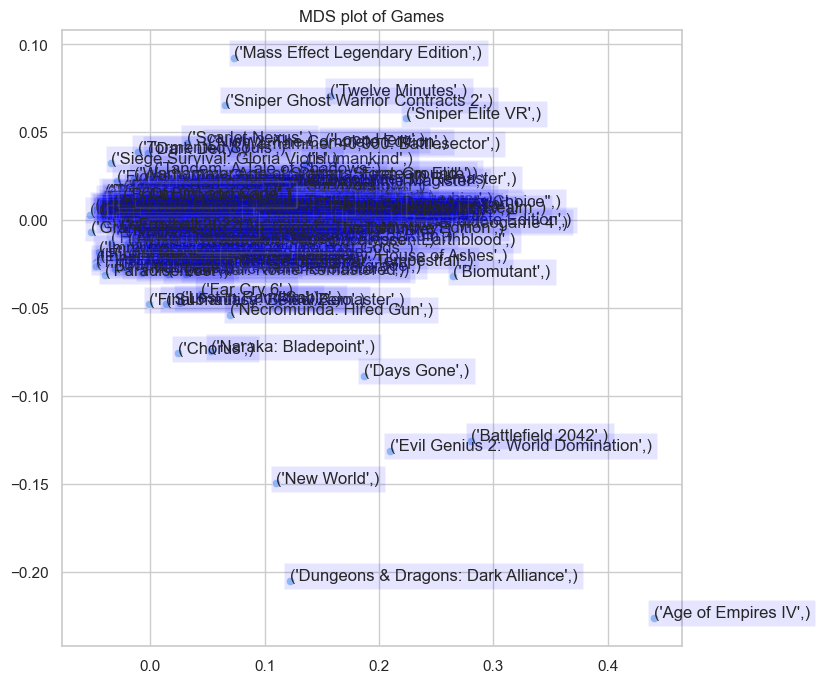

In [294]:
sns.scatterplot(xs,ys)
for i,game in enumerate(dist2.columns.values):
    plt.text(s=game, x= xs[i] , y=ys[i], bbox=dict(facecolor="blue",alpha=0.1))
plt.title('MDS plot of Games')
plt.savefig('MDSplot.png')
plt.show()

In [295]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:"#1e25a6"}

#set up cluster names using a dict
cluster_names = {0: 'C1', 
                 1: 'C2', 
                 2: 'C3'#, 
                 #3: 'C4', 
                 #4: 'C5',
                 #5: "C6"
                }

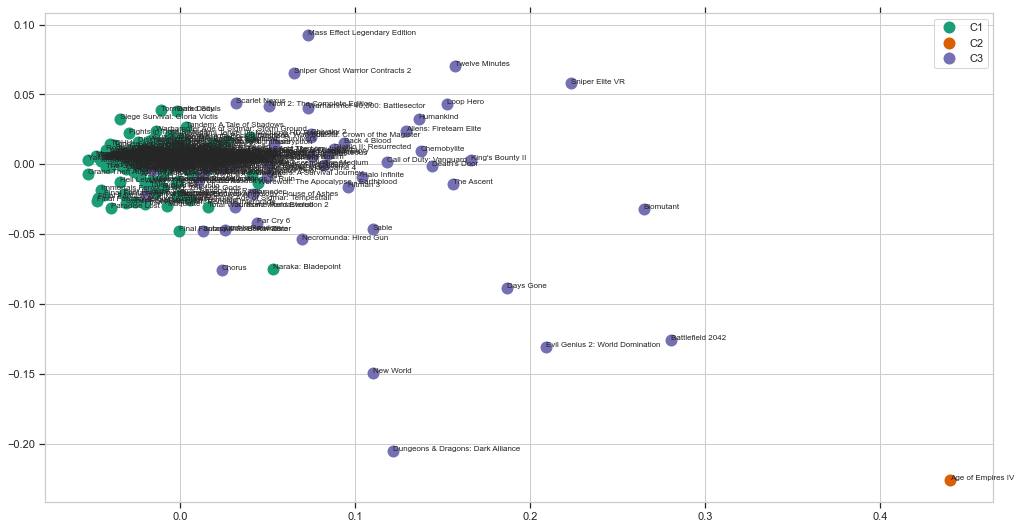

<Figure size 432x288 with 0 Axes>

In [296]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=gamenames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the game title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot


plt.savefig('clusters_graph.png')